# Intel Image Classification

Dans le cadre de notre projet d'intelligence artificielle, nous avons décidé d'étudier la reconnaissance d'image. Nous allons tester et comparer plusieurs modèles dans ce notebook. Nous allons d'abord examiner le jeu de données, puis nous testerons les modèles, enfin nous les comparerons.

Nous avons ici affaire à un problème de classification d'image. Nous allons donc implémenter un réseau convolutif avec Keras, ainsi que d'autres modèles de classification disponibles sur la librairie scikit-learn.

# Import des librairies

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

Installation de visualkeras qui n'est pas disponible en natif sur Kaggle.

In [2]:
!pip install git+https://github.com/paulgavrikov/visualkeras.git

  Cloning https://github.com/paulgavrikov/visualkeras.git to /tmp/pip-req-build-iyw15r5q
  Running command git clone --filter=blob:none -q https://github.com/paulgavrikov/visualkeras.git /tmp/pip-req-build-iyw15r5q
  Resolved https://github.com/paulgavrikov/visualkeras.git to commit d7111d3471173c0b16853a6ce5e4cc645498380a
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 992 kB 5.0 MB/s            
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13451 sha256=d4447604d65d7aa07f4d22fd3c3e28b587e7f686e29f81f421932874555e05a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xaikxrk8/wheels/aa/d2/f0/13512c05462c97546e547598df8a0898482e6e918dac82310d
Successfully built visualkeras


In [3]:
import visualkeras

In [4]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Chargement des données

Nous limitons le chargement des images à 200 images par classes pour pouvoir exécuter les modèles en un temps raisonnable et pallier au problème du manque de RAM.

In [5]:
def load_data(max_img_per_folder):
    """ max_img_per_folder : Max d'images à charger par dossier, 
        baisser ou augmenter en fonciton de la ram """

    datasets = ['../input/intel-image-classification/seg_train/seg_train', '../input/intel-image-classification/seg_test/seg_test']
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Chargement {}".format(dataset))
        
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Compteur d'images chargées
            i = 0 
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                if i < max_img_per_folder:
                    # Get the path name of the image
                    img_path = os.path.join(os.path.join(dataset, folder), file)

                    # Open and resize the img
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE) 

                    # Append the image and its corresponding label to the output
                    images.append(image)
                    labels.append(label)

                    i += 1
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int16')   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data(200)

Chargement ../input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:01<00:00, 1948.21it/s]


Chargement ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:01<00:00, 489.88it/s]


In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=31)

## Normalisation des données

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Exploration et visualisation des données

#### Visualisation brute

In [9]:
print("X: ")
print(train_images.shape)
print(train_images[:1])
print("y: ")
print(train_labels)

X: 
(1200, 150, 150, 3)
[[[[0.35686275 0.45882353 0.5882353 ]
   [0.32941177 0.45490196 0.6156863 ]
   [0.24705882 0.4117647  0.64705884]
   ...
   [0.44705883 0.57254905 0.72156864]
   [0.4509804  0.5764706  0.7254902 ]
   [0.4509804  0.5764706  0.7254902 ]]

  [[0.92941177 1.         1.        ]
   [0.7411765  0.84705883 0.9647059 ]
   [0.48235294 0.6156863  0.79607844]
   ...
   [0.44705883 0.57254905 0.72156864]
   [0.4509804  0.5764706  0.7254902 ]
   [0.45490196 0.5803922  0.7294118 ]]

  [[0.8745098  0.9254902  0.9490196 ]
   [0.9098039  0.9764706  1.        ]
   [0.89411765 0.9764706  1.        ]
   ...
   [0.44705883 0.57254905 0.7254902 ]
   [0.45882353 0.57254905 0.7294118 ]
   [0.4627451  0.5764706  0.73333335]]

  ...

  [[0.63529414 0.7176471  0.8       ]
   [0.5568628  0.6431373  0.7254902 ]
   [0.49803922 0.6039216  0.6784314 ]
   ...
   [0.56078434 0.63529414 0.7019608 ]
   [0.62352943 0.69803923 0.75686276]
   [0.6666667  0.7411765  0.8       ]]

  [[0.5294118  0.6392

#### Combien d'images avons-nous?

In [10]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Nombre d'images d'apprentissage: {}".format(n_train))
print ("Nombre d'images de test: {}".format(n_test))
print ("Taille des images: {}".format(IMAGE_SIZE))

Nombre d'images d'apprentissage: 1200
Nombre d'images de test: 1200
Taille des images: (150, 150)


#### Distribution des images

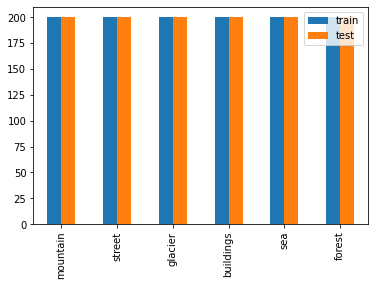

In [11]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

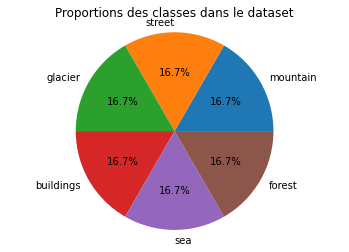

In [12]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportions des classes dans le dataset')
plt.show()

#### Exemple d'image

In [13]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

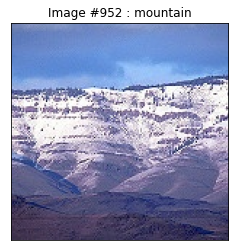

In [14]:
display_random_image(class_names, train_images, train_labels)

#### Plus d'exemples

In [15]:
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Exemples d'images du dataset", fontsize=16)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

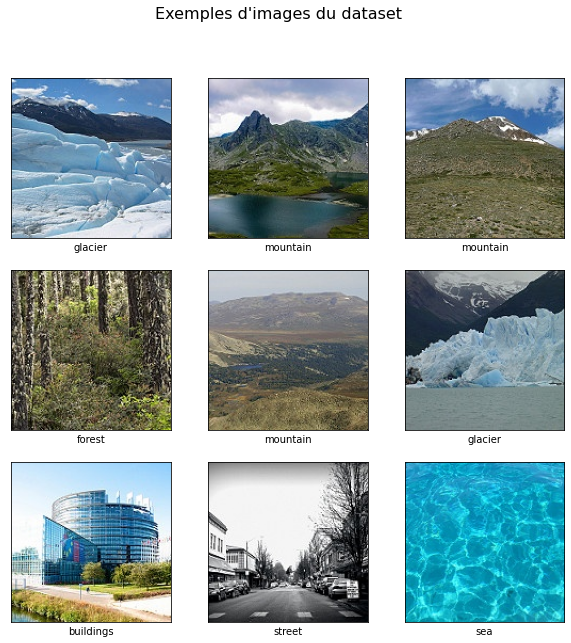

In [16]:
display_examples(class_names, train_images, train_labels)

# Réseau de neurones convolutif

Un premier modèle, un réseau de neurones convolutif simple réalisé avec Keras.

Le réseau convolutif que nous construisons aure la forme suivante:
* Conv2D: (32 filtres de taille 3x3): extraction des caractéristiques.
* MaxPooling2D: la taille de l'image est divisée par deux.
* Flatten: on réduit les dimensions.
* Softmax: 6 sorties pour les 6 classes (glacier, mountain...).

In [17]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

2022-03-06 21:13:45.856417: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Compilation

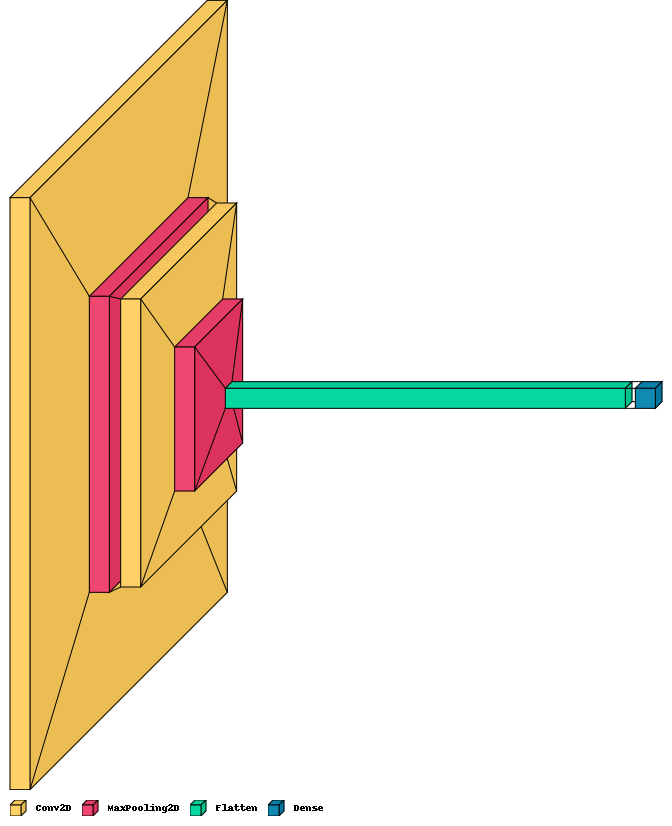

In [18]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
visualkeras.layered_view(cnn, to_file='cnn.png', legend=True)


#### Apprentissage

In [19]:
history = cnn.fit(train_images, train_labels, batch_size=64, epochs=15, validation_split = 0.2)
cnn_score = history.history['val_accuracy'][-1]
cnn_score

2022-03-06 21:13:46.365171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
15/15 [==============================] - 6s 368ms/step - loss: 1.7366 - accuracy: 0.3333 - val_loss: 1.2842 - val_accuracy: 0.5208
Epoch 2/15
15/15 [==============================] - 5s 331ms/step - loss: 1.1202 - accuracy: 0.5760 - val_loss: 1.1392 - val_accuracy: 0.6000
Epoch 3/15
15/15 [==============================] - 5s 342ms/step - loss: 0.9008 - accuracy: 0.6844 - val_loss: 1.0779 - val_accuracy: 0.5958
Epoch 4/15
15/15 [==============================] - 5s 332ms/step - loss: 0.7620 - accuracy: 0.7271 - val_loss: 1.1768 - val_accuracy: 0.5583
Epoch 5/15
15/15 [==============================] - 5s 367ms/step - loss: 0.7008 - accuracy: 0.7573 - val_loss: 1.1420 - val_accuracy: 0.6000
Epoch 6/15
15/15 [==============================] - 5s 334ms/step - loss: 0.5857 - accuracy: 0.8073 - val_loss: 1.1605 - val_accuracy: 0.5792
Epoch 7/15
15/15 [==============================] - 5s 338ms/step - loss: 0.4678 - accuracy: 0.8687 - val_loss: 1.1899 - val_accuracy: 0.6125
Epoch 

0.637499988079071

#### Courbes d'apprentissage

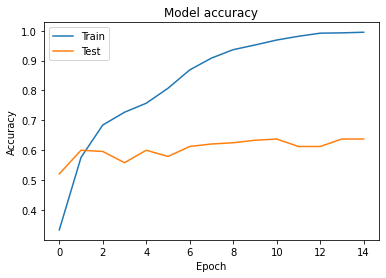

[0.5208333134651184, 0.6000000238418579, 0.5958333611488342, 0.5583333373069763, 0.6000000238418579, 0.5791666507720947, 0.612500011920929, 0.6208333373069763, 0.625, 0.6333333253860474, 0.637499988079071, 0.612500011920929, 0.612500011920929, 0.637499988079071, 0.637499988079071]


In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print(history.history['val_accuracy'])

#### Tentative de reconnaissance d'une image avec ce modèle

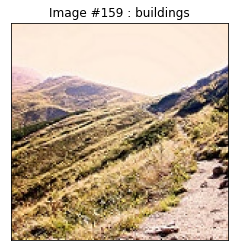

In [21]:
# La prédiction est sous forme d'un tableau de probabilités
predictions = cnn.predict(test_images)
# On choisit l'élément avec la plus grand probabilité
pred_labels = np.argmax(predictions, axis = 1)

display_random_image(class_names, test_images, pred_labels)

## Réduction des dimensions 
Pour faciliter l'usage des prochains modèles, on réduit les dimensions de nos tableaux descriptifs d'images.

In [22]:
print("Avant la réduction de dimensions: ")
print(train_images.shape)

flattened_list = []
for i in range(len(train_images)):
    flattened_list.append(train_images[i].ravel())

train_images = np.array(flattened_list)

flattened_list = []
for i in range(len(test_images)):
    flattened_list.append(test_images[i].ravel())

test_images = np.array(flattened_list)

print("Après la réduction de dimensions: ")
print(train_images.shape)


Avant la réduction de dimensions: 
(1200, 150, 150, 3)
Après la réduction de dimensions: 
(1200, 67500)


## SVM

Deuxième modèle, SVM (Support Vector Machine).

In [23]:
from sklearn import svm

svm = svm.SVC()
svm_history = svm.fit(train_images, train_labels)
svm_score = svm.score(test_images,test_labels)
svm_score

0.5375

## KNN (k-Nearest Neighbors)
Troisième modèle, KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 13)
knn_history = knn.fit(train_images, train_labels)
knn_score = knn.score(test_images, test_labels)
knn_score

0.36666666666666664

## Random Forest Classifier
Quatrième modèle, Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=31)
rfc.fit(train_images, train_labels)
rfc_score = rfc.score(test_images, test_labels)
rfc_score

0.5266666666666666

## Comparaison des scores

In [26]:
models = [cnn, svm, knn, rfc]
scores = [cnn_score, svm_score, knn_score, rfc_score]

res = pd.DataFrame({'Score': scores, 'Model': ['CNN', 'SVM', 'KNN', 'RFC']})
res.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Score,Model
0,0.637500,CNN
1,0.537500,SVM
2,0.526667,RFC
3,0.366667,KNN


Text(0.5, 1.0, 'Scores')

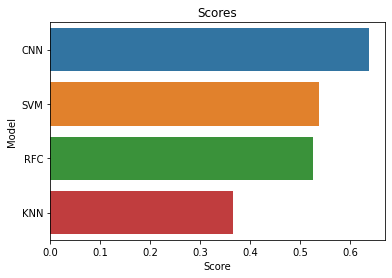

In [27]:
sn.barplot(x = 'Score', y = 'Model', data = res, order = res.sort_values(by = 'Score', ascending = False)['Model'])
plt.ylabel('Model')
plt.title('Scores')

On remarque que le réseau convolutif a de meilleurs résultats que les autres modèles. Le réseau convolutif offre également ces meilleurs résultats avec un temps d'apprentissage beaucoup moins élevé que les autres.